In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install wordcloud
!pip install gensim
!pip install nltk
!pip install spacy
!pip install transformers
!pip install wget
!pip install transformers
!pip install wget
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install torch

     |████████████████████████████████| 3.4MB 9.1MB/s 
     |████████████████████████████████| 1.1MB 7.5MB/s 
     |████████████████████████████████| 1.2MB 27.0MB/s 
     |████████████████████████████████| 645kB 32.1MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 358kB 40.1MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 174kB 52.7MB/s 
     |████████████████████████████████| 706kB 53.8MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 2.2MB 8.0MB/s 
     |████████████████████████████████| 870kB 49.6MB/s 
     |████████████████████████████████| 3.3MB 52.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=6e096283c45fc3768bf6a3f218f3f8612859f2ddd9ba1181dbafbe9a5fd14640
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successful

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases, phrases, ldamodel, CoherenceModel
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
import gensim.corpora as corpora
from pprint import pprint
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

## Data For Analysis

In [23]:
df = pd.read_csv('flipkart_data.csv')
df.shape

(20000, 15)

* From the **product_category_tree** we consider the ***primary*** catergory as the root of this tree.
<br>
* Example: For the category given tree <font color='darkblue'>'["Footwear >> Women's Footwear >> Ballerinas >> AW Bellies"]'</font> the primary category is **<font color='darkblue'>Footwear</font>**

In [24]:
df['product_category'] = df['product_category_tree'].str.strip('["*]"').str.split('>>').str[0].str.strip()

In [25]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications',
       'product_category'],
      dtype='object')

In [26]:
# Removing redunant columns
df.drop(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product','product_rating',
       'overall_rating', 'brand', 'product_specifications'],axis=1,inplace=True)

## Exploratory Data Analysis

<AxesSubplot:>

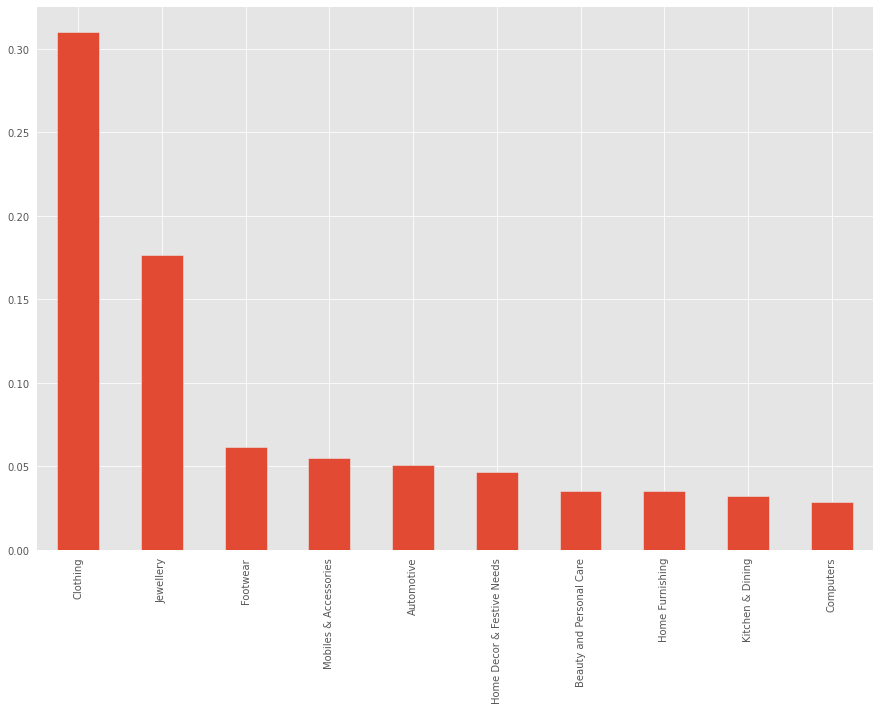

In [27]:
# Top 10 Product categories
df['product_category'].value_counts(normalize=True)[:10].plot(kind="bar")

In [28]:
data_df = df[['product_category','description']]
data_df.head()

,product_category,description
0,Clothing,Key Features of Alisha Solid Women's Cycling S...
1,Furniture,FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,Footwear,Key Features of AW Bellies Sandals Wedges Heel...
3,Clothing,Key Features of Alisha Solid Women's Cycling S...
4,Pet Supplies,Specifications of Sicons All Purpose Arnica Do...


In [29]:
data_df['Number_of_words'] = data_df['description'].apply(lambda x:len(str(x).split()))
data_df.head(1)

,product_category,description,Number_of_words
0,Clothing,Key Features of Alisha Solid Women's Cycling S...,64


<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='Number_of_words'>

Text(0.5, 1.0, 'Frequency distribution of number of words for each description')

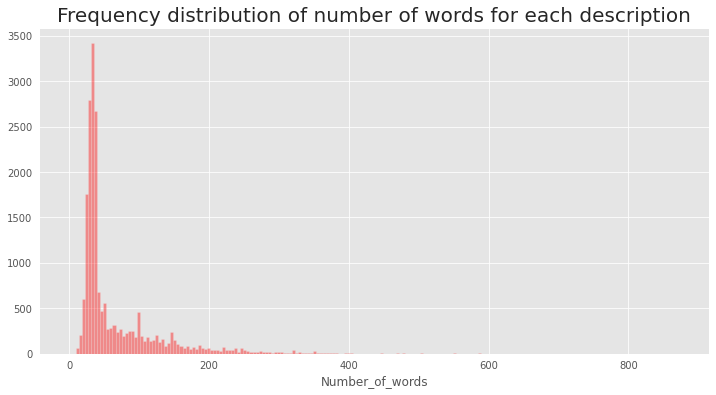

In [30]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data_df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each description", size=20)

(0.0, 1.0, 0.0, 1.0)

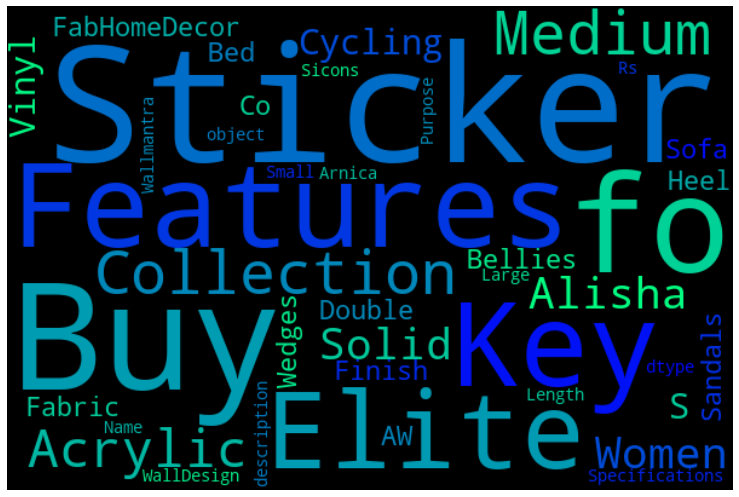

In [31]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(str(data_df["description"]))
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

## Data Cleaning

In [38]:
data_df.dropna(inplace=True)

In [39]:
data_df['description_processed'] = data_df['description'].map(lambda x: re.sub(r'[,\.!?()]','',x))
data_df['description_processed'] = data_df['description_processed'].map(lambda x:x.lower())
print(data_df['description_processed'].head())

0    key features of alisha solid women's cycling s...
1    fabhomedecor fabric double sofa bed finish col...
2    key features of aw bellies sandals wedges heel...
3    key features of alisha solid women's cycling s...
4    specifications of sicons all purpose arnica do...
Name: description_processed, dtype: object


In [40]:
# remove all characters, number or characters
def cleanText(input_string):
    modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
    return(modified_string)
data_df['description_processed'] = data_df.description_processed.apply(cleanText)
data_df['description_processed'][100]

'rorlig rr 028 expedition analog watch for men boys price rs 399 you will be bombarded with complimenting glances as you walk out wearing this brown black coloured analog watch featuring a stylish dial and attractive leather strap this watch will be a classy touch to your look this stylish accessory is a fine pick to flaunt with casuals as well as with formals too you will be bombarded with complimenting glances as you walk out wearing this brown black coloured analog watch featuring a stylish dial and attractive leather strap this watch will be a classy touch to your look this stylish accessory is a fine pick to flaunt with casuals as well as with formals too'

In [41]:
# remove stopwords
stopWords = stopwords.words('english')
def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
    return newtxt
data_df['description_processed'] = [removeStopWords(stopWords,x) for x in data_df['description_processed']]

In [42]:
data_df['description_processed'][150]

'casela cas w 13 basic analog watch boys girls buy casela cas w 13 basic analog watch boys girls cas w 13 online rs899 india flipkartcom great discounts genuine products 30 day replacement guarantee free shipping cash delivery'

(0.0, 1.0, 0.0, 1.0)

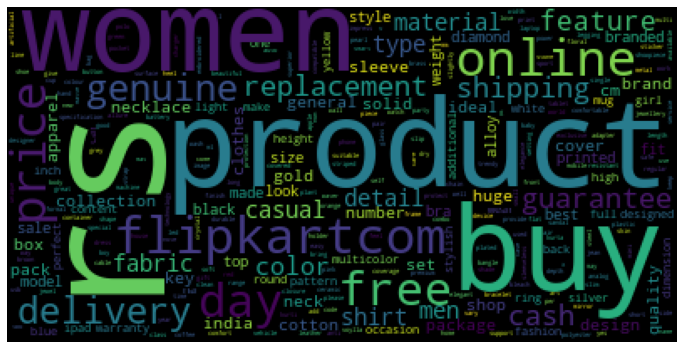

In [43]:
# join the different text together
longText = ','.join(list(data_df['description_processed'].values))
# generate the word cloud
wordcloud = WordCloud(background_color="black",
                      max_words= 600,
                      contour_width = 10,
                      contour_color = "steelblue",
                     collocations=False).generate(longText)
# visualize the word cloud
fig = plt.figure(1, figsize = (12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

<AxesSubplot:xlabel='words', ylabel='count'>

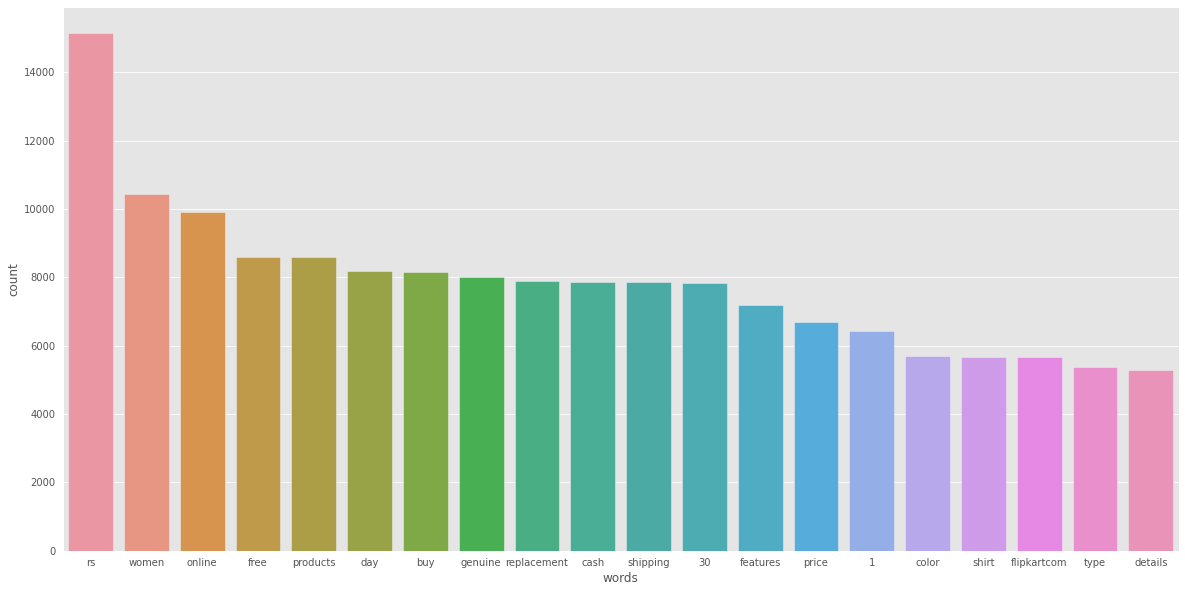

In [44]:
fig = plt.figure(1, figsize = (20,10))
# split() returns list of all the words in the string
split_it = longText.split()
# Pass the split_it list to instance of Counter class.
from collections import Counter
Counter = Counter(split_it)
#print(Counter)
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(20)
x_df = pd.DataFrame(most_occur, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = x_df)

## Data Preparation

Data preprocessing is done in the following fashion.
* **Tokenization** of the description of the product. (Post cleaning the description for the product).
* **Lemmatizing** the tokenized data in-order to prepare it for usagein the model.

In [46]:
nltk.download("punkt")
# word_tokenize 
data_df["tokenized"] = data_df["description_processed"].apply(lambda x: nltk.word_tokenize(x))
data_df["tokenized"] = data_df["tokenized"].apply(lambda words: [word for word in words if word.isalnum()])
data_df.head(2)

[nltk_data] Downloading package punkt to /home/delhivery/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

,product_category,description,Number_of_words,description_processed,tokenized
0,Clothing,Key Features of Alisha Solid Women's Cycling S...,64,key features alisha solid women cycling shorts...,"[key, features, alisha, solid, women, cycling,..."
1,Furniture,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,752,fabhomedecor fabric double sofa bed finish col...,"[fabhomedecor, fabric, double, sofa, bed, fini..."


In [47]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i, pos='v') for i in text]
    return lem_text


data_df["lemmatized"] = data_df["tokenized"].apply(
    lambda x: word_lemmatizer(x))
data_df["lemmatize_joined"] = data_df["lemmatized"].apply(
    lambda x: ' '.join(x))
pd.set_option('display.max_colwidth', 100)
data_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/delhivery/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

,product_category,description,Number_of_words,description_processed,tokenized,lemmatized,lemmatize_joined
0,Clothing,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications ...",64,key features alisha solid women cycling shorts cotton lycra navy red navyspecifications alisha s...,"[key, features, alisha, solid, women, cycling, shorts, cotton, lycra, navy, red, navyspecificati...","[key, feature, alisha, solid, women, cycle, short, cotton, lycra, navy, red, navyspecifications,...",key feature alisha solid women cycle short cotton lycra navy red navyspecifications alisha solid...
1,Furniture,FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out)...,752,fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs ...,"[fabhomedecor, fabric, double, sofa, bed, finish, color, leatherette, black, mechanism, type, pu...","[fabhomedecor, fabric, double, sofa, bed, finish, color, leatherette, black, mechanism, type, pu...",fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs ...
2,Footwear,"Key Features of AW Bellies Sandals Wedges Heel Casuals,AW Bellies Price: Rs. 499 Material: Synth...",107,key features aw bellies sandals wedges heel casualsaw bellies price rs 499 material synthetic li...,"[key, features, aw, bellies, sandals, wedges, heel, casualsaw, bellies, price, rs, 499, material...","[key, feature, aw, belly, sandals, wedge, heel, casualsaw, belly, price, rs, 499, material, synt...",key feature aw belly sandals wedge heel casualsaw belly price rs 499 material synthetic lifestyl...
3,Clothing,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Black, Red,Specifications of Al...",63,key features alisha solid women cycling shorts cotton lycra black redspecifications alisha solid...,"[key, features, alisha, solid, women, cycling, shorts, cotton, lycra, black, redspecifications, ...","[key, feature, alisha, solid, women, cycle, short, cotton, lycra, black, redspecifications, alis...",key feature alisha solid women cycle short cotton lycra black redspecifications alisha solid wom...
4,Pet Supplies,Specifications of Sicons All Purpose Arnica Dog Shampoo (500 ml) General Pet Type Dog Brand Sico...,40,specifications sicons purpose arnica dog shampoo 500 ml general pet type dog brand sicons quanti...,"[specifications, sicons, purpose, arnica, dog, shampoo, 500, ml, general, pet, type, dog, brand,...","[specifications, sicons, purpose, arnica, dog, shampoo, 500, ml, general, pet, type, dog, brand,...",specifications sicons purpose arnica dog shampoo 500 ml general pet type dog brand sicons quanti...


<Figure size 1008x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, '30 most frequent words')

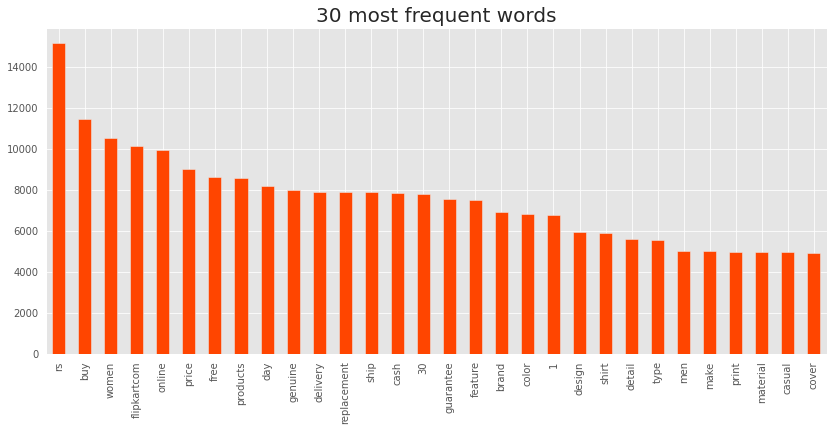

In [48]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(data_df["lemmatize_joined"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 most frequent words",size=20)

## Model Preparation and Training

* Here we are removing all the product categories for which less than 10 products are present.

In [49]:
data_df['category_count'] = data_df.groupby(['product_category'])['description'].transform('count')
data_df = data_df[data_df['category_count']>10]

possible_labels = data_df.product_category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Clothing': 0,
 'Furniture': 1,
 'Footwear': 2,
 'Pet Supplies': 3,
 'Pens & Stationery': 4,
 'Sports & Fitness': 5,
 'Beauty and Personal Care': 6,
 'Bags, Wallets & Belts': 7,
 'Home Decor & Festive Needs': 8,
 'Automotive': 9,
 'Tools & Hardware': 10,
 'Home Furnishing': 11,
 'Baby Care': 12,
 'Mobiles & Accessories': 13,
 'Watches': 14,
 'Toys & School Supplies': 15,
 'Jewellery': 16,
 'Sunglasses': 17,
 'Kitchen & Dining': 18,
 'Home & Kitchen': 19,
 'Computers': 20,
 'Cameras & Accessories': 21,
 'Health & Personal Care Appliances': 22,
 'Gaming': 23,
 'Home Improvement': 24,
 'Home Entertainment': 25,
 'eBooks': 26}

* Providing labels for each category

In [51]:
data_df['label'] = data_df.product_category.replace(label_dict)
data_df.head(2)

,product_category,description,Number_of_words,description_processed,tokenized,lemmatized,lemmatize_joined,category_count,label
0,Clothing,"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications ...",64,key features alisha solid women cycling shorts cotton lycra navy red navyspecifications alisha s...,"[key, features, alisha, solid, women, cycling, shorts, cotton, lycra, navy, red, navyspecificati...","[key, feature, alisha, solid, women, cycle, short, cotton, lycra, navy, red, navyspecifications,...",key feature alisha solid women cycle short cotton lycra navy red navyspecifications alisha solid...,6197,0
1,Furniture,FabHomeDecor Fabric Double Sofa Bed (Finish Color - Leatherette Black Mechanism Type - Pull Out)...,752,fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs ...,"[fabhomedecor, fabric, double, sofa, bed, finish, color, leatherette, black, mechanism, type, pu...","[fabhomedecor, fabric, double, sofa, bed, finish, color, leatherette, black, mechanism, type, pu...",fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price rs ...,180,1


In [56]:
data_df = data_df[['label','lemmatize_joined']]

In [57]:
data_df.columns

Index(['label', 'lemmatize_joined'], dtype='object')

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_df.index.values, 
                                                  data_df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=data_df.label.values)

data_df['data_type'] = ['not_set']*data_df.shape[0]
    
data_df.loc[X_train, 'data_type'] = 'train'
data_df.loc[X_val, 'data_type'] = 'val'

# data_df.groupby(['product_category', 'label', 'data_type'])['lemmatize_joined'].count().reset_index()

In [59]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    data_df[data_df.data_type=='train'].lemmatize_joined.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data_df[data_df.data_type=='val'].lemmatize_joined.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data_df[data_df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data_df[data_df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [60]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [61]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [62]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [65]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [72]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [54]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.1178790534985487
Validation loss: 0.2028807924012757
F1 Score (Weighted): 0.9636441557460519



Epoch 2
Training loss: 0.08104871575743214
Validation loss: 0.16511837454839437
F1 Score (Weighted): 0.9718653232265749



Epoch 3
Training loss: 0.04304249854788262
Validation loss: 0.17076467521709676
F1 Score (Weighted): 0.9740138720277448



Epoch 4
Training loss: 0.025366300164061304
Validation loss: 0.15305931800355793
F1 Score (Weighted): 0.9792079018736954



Epoch 5
Training loss: 0.018742394280544406
Validation loss: 0.15305931800355793
F1 Score (Weighted): 0.9792079018736954



In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [69]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [60]:
accuracy_per_class(predictions, true_vals)

Class: Clothing
Accuracy: 926/930

Class: Furniture
Accuracy: 23/27

Class: Footwear
Accuracy: 184/184

Class: Pet Supplies
Accuracy: 3/4

Class: Pens & Stationery
Accuracy: 32/47

Class: Sports & Fitness
Accuracy: 20/25

Class: Beauty and Personal Care
Accuracy: 102/107

Class: Bags, Wallets & Belts
Accuracy: 39/40

Class: Home Decor & Festive Needs
Accuracy: 136/139

Class: Automotive
Accuracy: 151/152

Class: Tools & Hardware
Accuracy: 59/59

Class: Home Furnishing
Accuracy: 105/105

Class: Baby Care
Accuracy: 55/72

Class: Mobiles & Accessories
Accuracy: 154/165

Class: Watches
Accuracy: 80/80

Class: Toys & School Supplies
Accuracy: 40/49

Class: Jewellery
Accuracy: 529/530

Class: Sunglasses
Accuracy: 6/6

Class: Kitchen & Dining
Accuracy: 92/97

Class: Home & Kitchen
Accuracy: 0/4

Class: Computers
Accuracy: 86/87

Class: Cameras & Accessories
Accuracy: 12/12

Class: Health & Personal Care Appliances
Accuracy: 3/6

Class: Gaming
Accuracy: 2/5

Class: Home Improvement
Accuracy: 9